# ResNet18 X-ray classification

Training a binary classifier (healthy vs necrosis) on TIFFs from `.data/output` with a stratified 90/10 split using `tazotron.nn.resnet18`.


## Imports & config

In [1]:
# ruff: noqa: I001
from __future__ import annotations

import json
import random
from collections.abc import Sequence  # noqa: TC003
from pathlib import Path

from PIL import Image
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm.auto import tqdm

from tazotron.nn.resnet18 import ResNet18


### Reproducibility

In [2]:
def set_seed(seed: int = 42) -> None:
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.use_deterministic_algorithms(mode=False)

set_seed(42)


### Paths and hyperparameters

In [3]:
DATA_ROOT = Path("../../.data/output")
METADATA_PATH = DATA_ROOT / "metadata.json"
TEST_RATIO = 0.10  # stratified hold-out
VAL_RATIO = 0.10   # of the remaining train split
IMG_SIZE = 224
BATCH_SIZE = 8
EPOCHS = 10
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
DROPOUT = 0.3
NUM_WORKERS = 4


## Device

In [4]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
PIN_MEMORY = device.type == "cuda"
EFFECTIVE_WORKERS = NUM_WORKERS if device.type == "cuda" else 0
device


device(type='mps')

## Dataset helpers

In [5]:
def load_samples(data_root: Path, meta_path: Path) -> list[dict]:
    meta = json.loads(meta_path.read_text())
    items: list[dict] = []
    for path in sorted(data_root.glob("*.tiff")):
        key = path.stem
        necro = meta.get(key)
        if necro is None:
            continue
        label = 0 if necro == 0 else 1
        items.append({"path": path, "label": label, "necro": int(necro)})
    return items

def stratified_split(items: Sequence[dict], test_ratio: float, val_ratio: float, seed: int = 42):
    rng = random.Random(seed)  # noqa: S311
    by_label: dict[int, list[dict]] = {0: [], 1: []}
    for item in items:
        by_label[item["label"]].append(item)
    for values in by_label.values():
        rng.shuffle(values)
    train: list[dict] = []
    val: list[dict] = []
    test: list[dict] = []
    for values in by_label.values():
        n = len(values)
        n_test = max(1, round(n * test_ratio)) if n > 0 else 0
        n_remaining = n - n_test
        n_val = max(1, round(n_remaining * val_ratio)) if n_remaining > 1 else 0
        test.extend(values[:n_test])
        val.extend(values[n_test : n_test + n_val])
        train.extend(values[n_test + n_val :])
    return train, val, test

class XrayDataset(Dataset):
    def __init__(self, entries: Sequence[dict], transform: transforms.Compose) -> None:
        self.entries = list(entries)
        self.transform = transform

    def __len__(self) -> int:
        return len(self.entries)

    def __getitem__(self, idx: int):
        entry = self.entries[idx]
        image = Image.open(entry["path"]).convert("F")
        tensor = transforms.functional.to_tensor(image)
        if self.transform is not None:
            tensor = self.transform(tensor)
        label = torch.tensor(entry["label"], dtype=torch.long)
        return {"image": tensor, "label": label, "necro": entry["necro"], "path": str(entry["path"])}


### Build splits

In [6]:
samples = load_samples(DATA_ROOT, METADATA_PATH)
train_entries, val_entries, test_entries = stratified_split(
    samples, test_ratio=TEST_RATIO, val_ratio=VAL_RATIO, seed=42,
)
len(train_entries), len(val_entries), len(test_entries)


(82, 8, 10)

### Transforms & loaders

In [7]:
def to_three_channels(img: torch.Tensor) -> torch.Tensor:
    return img.expand(3, -1, -1)

train_transform = transforms.Compose([
    transforms.Lambda(to_three_channels),
    transforms.Resize((IMG_SIZE, IMG_SIZE), antialias=True),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])
eval_transform = transforms.Compose([
    transforms.Lambda(to_three_channels),
    transforms.Resize((IMG_SIZE, IMG_SIZE), antialias=True),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

train_ds = XrayDataset(train_entries, train_transform)
val_ds = XrayDataset(val_entries, eval_transform)
test_ds = XrayDataset(test_entries, eval_transform)

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=EFFECTIVE_WORKERS,
    pin_memory=PIN_MEMORY,
)
val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=EFFECTIVE_WORKERS,
    pin_memory=PIN_MEMORY,
)
test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=EFFECTIVE_WORKERS,
    pin_memory=PIN_MEMORY,
)
len(train_ds), len(val_ds), len(test_ds)


(82, 8, 10)

## Model & optimizer

In [8]:
model = ResNet18(num_classes=2, dropout=DROPOUT).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2)


## Train

In [9]:
def run_epoch(loader: DataLoader, *, is_train: bool) -> tuple[float, float]:
    if is_train:
        model.train()
    else:
        model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    for batch in tqdm(loader, desc="train" if is_train else "eval", leave=False):
        inputs = batch["image"].to(device)
        targets = batch["label"].to(device)
        if is_train:
            optimizer.zero_grad()
        with torch.set_grad_enabled(is_train):
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            if is_train:
                loss.backward()
                optimizer.step()
        total_loss += loss.item() * inputs.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == targets).sum().item()
        total += targets.size(0)
    return total_loss / max(1, total), correct / max(1, total)

history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
for epoch in range(EPOCHS):
    train_loss, train_acc = run_epoch(train_loader, is_train=True)
    val_loss, val_acc = run_epoch(val_loader, is_train=False)
    scheduler.step(val_loss)
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)
    print(
        f"Epoch {epoch + 1}/{EPOCHS} - train_loss {train_loss:.4f} acc {train_acc:.3f} | "
        f"val_loss {val_loss:.4f} acc {val_acc:.3f}"
    )


train:   0%|          | 0/11 [00:00<?, ?it/s]

eval:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/10 - train_loss 0.7080 acc 0.463 | val_loss 0.7064 acc 0.500


train:   0%|          | 0/11 [00:00<?, ?it/s]

eval:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/10 - train_loss 0.7136 acc 0.451 | val_loss 0.7098 acc 0.500


train:   0%|          | 0/11 [00:00<?, ?it/s]

eval:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/10 - train_loss 0.6943 acc 0.561 | val_loss 0.7017 acc 0.500


train:   0%|          | 0/11 [00:00<?, ?it/s]

eval:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/10 - train_loss 0.7058 acc 0.451 | val_loss 0.6946 acc 0.500


train:   0%|          | 0/11 [00:00<?, ?it/s]

eval:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/10 - train_loss 0.6969 acc 0.512 | val_loss 0.6926 acc 0.500


train:   0%|          | 0/11 [00:00<?, ?it/s]

eval:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/10 - train_loss 0.6852 acc 0.598 | val_loss 0.6981 acc 0.500


train:   0%|          | 0/11 [00:00<?, ?it/s]

eval:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/10 - train_loss 0.6983 acc 0.512 | val_loss 0.7013 acc 0.500


train:   0%|          | 0/11 [00:00<?, ?it/s]

eval:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/10 - train_loss 0.7088 acc 0.415 | val_loss 0.6900 acc 0.500


train:   0%|          | 0/11 [00:00<?, ?it/s]

eval:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/10 - train_loss 0.7036 acc 0.488 | val_loss 0.6893 acc 0.500


train:   0%|          | 0/11 [00:00<?, ?it/s]

eval:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/10 - train_loss 0.6992 acc 0.488 | val_loss 0.6940 acc 0.500


## Learning curves

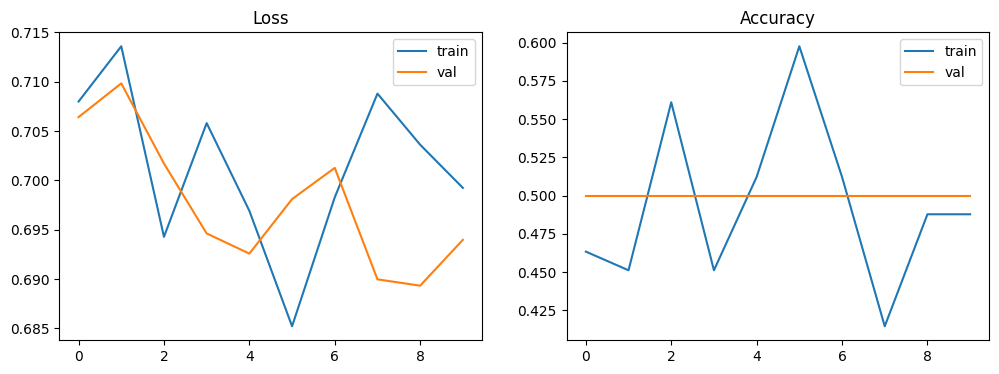

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(history["train_loss"], label="train")
axes[0].plot(history["val_loss"], label="val")
axes[0].set_title("Loss")
axes[0].legend()
axes[1].plot(history["train_acc"], label="train")
axes[1].plot(history["val_acc"], label="val")
axes[1].set_title("Accuracy")
axes[1].legend()
plt.show()


## Test metrics

In [11]:
def evaluate(loader: DataLoader):
    model.eval()
    total = 0
    correct = 0
    tp = fp = fn = 0
    with torch.no_grad():
        for batch in tqdm(loader, desc="test", leave=False):
            inputs = batch["image"].to(device)
            targets = batch["label"].to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            correct += (preds == targets).sum().item()
            total += targets.size(0)
            tp += ((preds == 1) & (targets == 1)).sum().item()
            fp += ((preds == 1) & (targets == 0)).sum().item()
            fn += ((preds == 0) & (targets == 1)).sum().item()
    accuracy = correct / max(1, total)
    precision = tp / max(1, tp + fp)
    recall = tp / max(1, tp + fn)
    f1 = 2 * precision * recall / max(1e-8, precision + recall)
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

test_metrics = evaluate(test_loader)
test_metrics


test:   0%|          | 0/2 [00:00<?, ?it/s]

{'accuracy': 0.5, 'precision': 0.5, 'recall': 1.0, 'f1': 0.6666666666666666}